<a href="https://colab.research.google.com/github/victorsergio/GNN-trajectory-prediction-2023/blob/main/sac_baseline_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Jan 31 23:40:36 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    47W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle as pkl

# EXPERIMENT PARAMETERS
in_timesteps = 10
out_timesteps = 10
in_features = 5
out_features = 2

# Run name
wandb_project_name = "baseline-model-50"

train_dataset_path = "/content/drive/MyDrive/PHD_2022/SAC/data/INTERACTION-Dataset-DR-single-v1_2/train/50m-DR_USA_Intersection_MA_train.csv"
test_dataset_path = '/content/drive/MyDrive/PHD_2022/SAC/data/INTERACTION-Dataset-DR-single-v1_2/train/50m-DR_USA_Intersection_MA_test.csv'

scaler_save_path = '/content/drive/MyDrive/PHD_2022/SAC/models/baseline/baseline_train_scaler.pkl'
scaler_reload_path = '/content/drive/MyDrive/PHD_2022/SAC/models/baseline/baseline_train_scaler.pkl'

model_save_path = '/content/drive/MyDrive/PHD_2022/SAC/models/baseline/'
model_reload_path = '/content/drive/MyDrive/PHD_2022/SAC/models/baseline/'

csv_out_path_train = '/content/drive/MyDrive/PHD_2022/SAC/results/50m-DR_USA_Intersection_MA_train_baseline_results.csv'
csv_out_path_test = '/content/drive/MyDrive/PHD_2022/SAC/results/50m-DR_USA_Intersection_MA_test_baseline_results.csv'



**METRICS**

In [17]:
# ADE function (single)

import math
def average_displacement_error(pred,ground):

    e = []

    for p,g in zip(pred,ground):
        e.append( math.sqrt (((p[0] - g[0]) ** 2) + ((p[1] - g[1]) ** 2)))

    return np.sum(e)/len(e)


In [18]:
# ADE function over BATCH (mean)

def calculate_error_batch(results, ground):

    e = [] 

    for r, g in zip(results, ground):
        e.append(average_displacement_error(r,g))
    
    return np.sum(e)/len(e)


In [4]:
import wandb
from wandb.keras import WandbCallback

wandb.init(project=wandb_project_name)

#wandb
wandb_callback = WandbCallback(monitor='val_loss', mode='min', log_gradients=False,save_model=False)

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: victorsergio. Use `wandb login --relogin` to force relogin


**START**

In [5]:
# Load clustered dataset
dataframe = pd.read_csv(train_dataset_path, sep=',')
# This is the train dataframe without normalization, it will be needed after to write the results to disk .csv
dataframe_raw = dataframe   

In [6]:
# Scaling
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

def scale_full_dataframe(dataframe, scaler_reload_path):

    dataframe_scaled = dataframe[["x", "y", "vx", "vy","psi_rad"]]
    dataframe = dataframe.drop(columns=["x", "y", "vx", "vy","psi_rad"], axis=1) # Keep only meta-data features

    if scaler_reload_path is not None: # if this is test set
        scaler = pd.read_pickle(scaler_reload_path)
    else:
        scaler = MinMaxScaler()

    dataframe_scaled = pd.DataFrame(scaler.fit_transform(dataframe_scaled), columns=["x", "y", "vx", "vy","psi_rad"])

    dataframe = pd.concat([dataframe, dataframe_scaled], axis=1)
    
    if scaler_reload_path is None:  # if this is training set save scaler to file
        # Save scaler to file
        
        with open(scaler_save_path, "wb") as outfile:
            pkl.dump(scaler, outfile)

    return dataframe


In [7]:
dataframe = scale_full_dataframe(dataframe, scaler_reload_path = None)  # not send a pre-calculated scaler because this is training set

In [8]:
def split_groups(dataframe):

    case_id = dataframe.groupby(["case_id", "label"])

    scenary_x = []
    scenary_y = []



    for ix,element in case_id:
        l = element.groupby(["track_id"])
    
        agents = [] # n trajectories (scenary-(aka: cluster)), one per agent

        # Get all scenary-(aka:cluster) trajectories
        for ig, eg in l:
            feat = eg[["x", "y", "vx", "vy","psi_rad"]]
            f_list = feat.values.tolist()
            agents.append(f_list)
    
        # separate each trajectory

        for tj in agents:
            temp = np.array(tj)
            temp_x = temp[0:in_timesteps,:]  # 0:10,:
            temp_y = temp[in_timesteps:,0:out_features]  # 10:, 0:2 only predict x,y

            d_x = np.hstack((temp_x))
            d_x = d_x.reshape(in_timesteps,1,in_features) # in_timesteps=10, 1= only one car, in_features = 5 features

            d_y = np.hstack((temp_y))
            d_y = d_y.reshape(out_timesteps,1,out_features) # out_timesteps=10, 1=only one car, out_features = 2 features

            scenary_x.append(d_x)
            scenary_y.append(d_y)   

    return np.array(scenary_x),np.array(scenary_y)

In [9]:
scene_x_train,scene_y_train = split_groups(dataframe) # unfold groups

# Print training shape
print(scene_x_train.shape)
print(scene_y_train.shape)

(31778, 10, 1, 5)
(31778, 10, 1, 2)


In [10]:
def to_single_agent_predictor(scene_x_train,scene_y_train):

    # Split dataset to be used as single agent model predictor, remove single group dimension

    n_samples_train = scene_x_train.shape[0]

    scene_x_train = tf.transpose(scene_x_train, [2, 0, 1, 3])
    scene_x_train = tf.reshape(scene_x_train, (n_samples_train * 1, in_timesteps, in_features))  #batch*nodes, seq_len, feat

    scene_y_train = tf.transpose(scene_y_train, [2, 0, 1, 3])
    scene_y_train = tf.reshape(scene_y_train, (n_samples_train * 1, out_timesteps, out_features))  #batch*nodes, seq_len, feat =  2, only predict x,y

    print(scene_x_train.shape)
    print(scene_y_train.shape)

    return scene_x_train, scene_y_train


In [11]:
scene_x_train, scene_y_train =  to_single_agent_predictor(scene_x_train,scene_y_train)

(31778, 10, 5)
(31778, 10, 2)


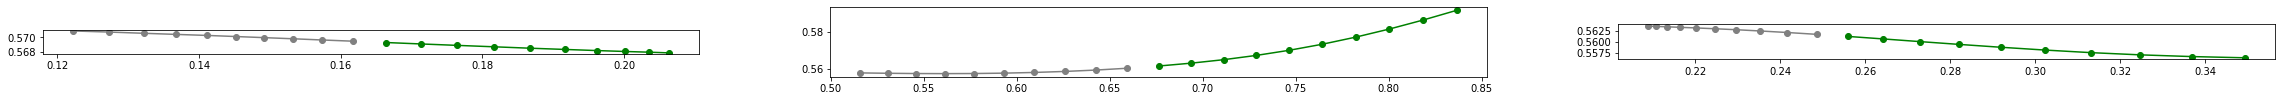

In [49]:
# Display single trajectories

def print_single_trajectory(prev_list,ground_list,prediction_list,n,ix,debug=False):
    
    prev = prev_list[ix:ix+n]
    ground = ground_list[ix:ix+n]

    if prediction_list is not None:
        pred = prediction_list[ix:ix+n]

   
    fig, ax = plt.subplots(1,n,figsize=(40,5))   


    for i,p in enumerate(prev):
        
        g = ground[i]

        p = tf.transpose(p,[1,0]) 
        g = tf.transpose(g,[1,0])

        ax[i].set_aspect('equal')
        ax[i].plot(p[0], p[1],'-o',color='gray',linestyle='solid')
        ax[i].plot(g[0], g[1],'-o',color='green',linestyle='solid')


        # if you want to print predictions and ground truths at the same time
        if prediction_list is not None:
            r = pred[i]
            r = tf.transpose(r,[1,0])
            ax[i].set_aspect('equal')
            ax[i].plot(r[0], r[1],'-o',color='red',linestyle='solid')
            
            if (debug):
                print("forecasted: ", r.numpy())
                print("truth: ", g.numpy())

            print("ADE error: ", average_displacement_error(r.numpy(),g.numpy())) # Difference between predicted and ground truth


    plt.show()

print_single_trajectory(scene_x_train,scene_y_train,None,3,400)

In [13]:
import tensorflow as tf

input_layer = tf.keras.Input(shape=(in_timesteps,in_features)) # in_seq_len = 10, in_features = 5

encoder = tf.keras.layers.LSTM(2048, return_sequences=False)(input_layer)
latent_vector = tf.keras.layers.RepeatVector(10)(encoder)  #  RepeatVector = 10 = out_timesteps  !Attention
decoder = tf.keras.layers.LSTM(1024, return_sequences=True)(latent_vector)
decoder_last = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=out_features, activation='relu'))(decoder) # units= 2 because we are only predicting x,y

model = tf.keras.Model(input_layer, decoder_last)

model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['mse', 'mae']) #0.00003

#uncomment this line to show model summary
#print(model.summary())

In [ ]:
# uncomment this line to load a pre-trained model file for re-training only
#model = tf.keras.models.load_model(model_reload_path)

In [14]:
# early stopping
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta = 0.0000000000000005, patience=30, mode='min', restore_best_weights=True) #0.00005

# callbacks
callbacks_list = [wandb_callback,early_stopping_callback]

In [15]:
# Model training
from sklearn.utils import shuffle
model.fit(
    scene_x_train, scene_y_train, 
    validation_split=0.2,
    batch_size = 32, #128
    epochs=4000,  #1000
    shuffle = True,
    callbacks=callbacks_list,
)

Epoch 1/4000
795/795 [==============================] - 12s 10ms/step - loss: 0.0054 - mse: 0.0054 - mae: 0.0335 - val_loss: 3.0560e-04 - val_mse: 3.0560e-04 - val_mae: 0.0115
Epoch 2/4000
795/795 [==============================] - 7s 9ms/step - loss: 2.8799e-04 - mse: 2.8799e-04 - mae: 0.0119 - val_loss: 1.9714e-04 - val_mse: 1.9714e-04 - val_mae: 0.0098
Epoch 3/4000
795/795 [==============================] - 7s 9ms/step - loss: 1.9886e-04 - mse: 1.9886e-04 - mae: 0.0100 - val_loss: 2.7647e-04 - val_mse: 2.7647e-04 - val_mae: 0.0120
Epoch 4/4000
795/795 [==============================] - 7s 9ms/step - loss: 1.5168e-04 - mse: 1.5168e-04 - mae: 0.0086 - val_loss: 1.1639e-04 - val_mse: 1.1639e-04 - val_mae: 0.0073
Epoch 5/4000
795/795 [==============================] - 7s 9ms/step - loss: 1.2593e-04 - mse: 1.2593e-04 - mae: 0.0078 - val_loss: 1.3849e-04 - val_mse: 1.3849e-04 - val_mae: 0.0083
Epoch 6/4000
795/795 [==============================] - 7s 9ms/step - loss: 1.1297e-04 - mse: 1.

In [16]:
# save the model in tensorflow format
model.save(model_save_path)

**EVALUATION OF MODEL'S PERFORMANCE**

**TRAINING EVALUATION**

In [19]:
# Evaluate to get MSE error over training set
y_pred = model.evaluate(scene_x_train,scene_y_train)

994/994 [==============================] - 4s 4ms/step - loss: 8.0121e-06 - mse: 8.0121e-06 - mae: 0.0016


In [20]:
# Predictions over training set (Normalized)

results_train = model.predict(scene_x_train)

# Uncomment if you are interested on calculate ADE over normalized trajectories
#print('Error ADE training (normalized): ',calculate_error_batch(results,scene_y_train))

994/994 [==============================] - 4s 3ms/step


**DE-NORMALIZATION EVALUATION**

In [21]:
# De-normalization to calculate metrics in meters scale

def denormalize_x_y_r(scene_x_train,scene_y_train,results,scaler_reload_path):

    scene_x_train_inv = tf.reshape(scene_x_train, [-1, in_features]).numpy()
    scene_y_train_inv = tf.reshape(scene_y_train, [-1, out_features]).numpy()
    results_inv = np.reshape(results, (-1,out_features))

    # Reload Original Scaler Train with all features
    scaler =  pd.read_pickle(scaler_reload_path) 

    # Create a new scaler only for x,y features, because the first scaler contains all the input features
    scaler_feat = MinMaxScaler()
    scaler_feat.n_features_in=out_features
    scaler_feat.min_,scaler_feat.scale_= [scaler.min_[0],scaler.min_[1]],[scaler.scale_[0],scaler.scale_[1]]

    results_inv = scaler_feat.inverse_transform(results_inv)
    scene_x_train_inv = scaler.inverse_transform(scene_x_train_inv)   #Attention to make use of original full scaler with 5 features
    scene_y_train_inv = scaler_feat.inverse_transform(scene_y_train_inv)

    results_inv = np.reshape(results_inv, (-1,out_timesteps,out_features)) #n_samples,timesteps=10,out features=2
    scene_y_train_inv = np.reshape(scene_y_train_inv,(-1,out_timesteps,out_features)) #n_samples,timesteps=10,out features=2
    scene_x_train_inv = np.reshape(scene_x_train_inv, (-1,in_timesteps,in_features))  #Attention to use the orginal 5 features from original X

    return scene_x_train_inv, scene_y_train_inv, results_inv

In [22]:
scene_x_train_inv,scene_y_train_inv,results_train_inv = denormalize_x_y_r(scene_x_train,scene_y_train,results_train,scaler_reload_path)

In [23]:
print("Train error ADE(m): ",calculate_error_batch(results_train_inv,scene_y_train_inv)) # Error in meters (De-normalized)

Train error ADE(m):  0.25120450291644286


ADE error:  0.0014430189788611552
ADE error:  0.0010429004858223123
ADE error:  0.001373807835962465


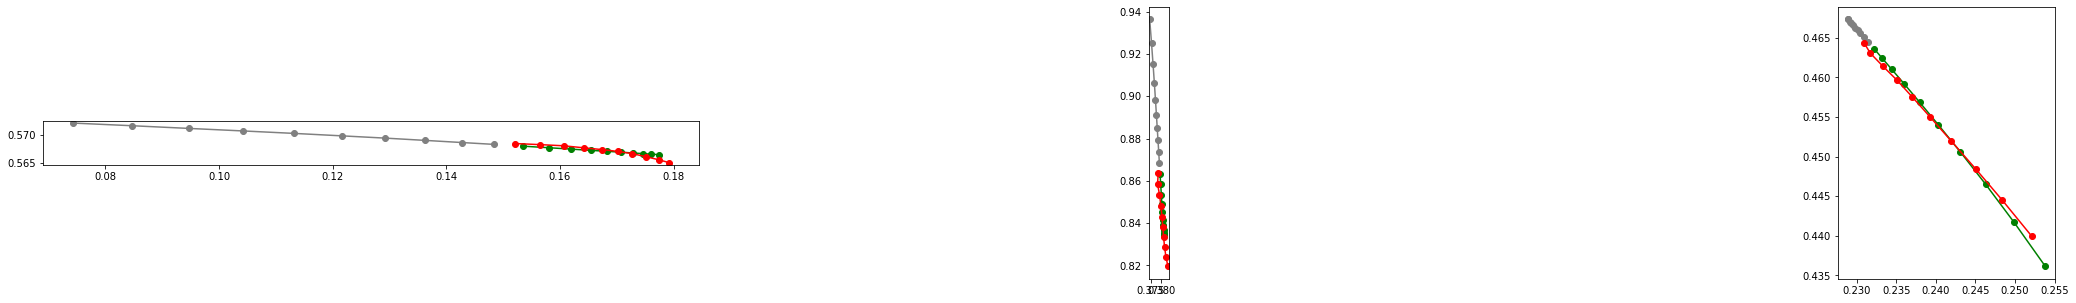

In [50]:
# Examples of predictions over training, (note the equal graphs for norm and de-norm trajectories)
print_single_trajectory(scene_x_train,scene_y_train, results_train,3,20)  # n,index

ADE error:  0.15089316330081212
ADE error:  0.11254138211587193
ADE error:  0.13939849017770264


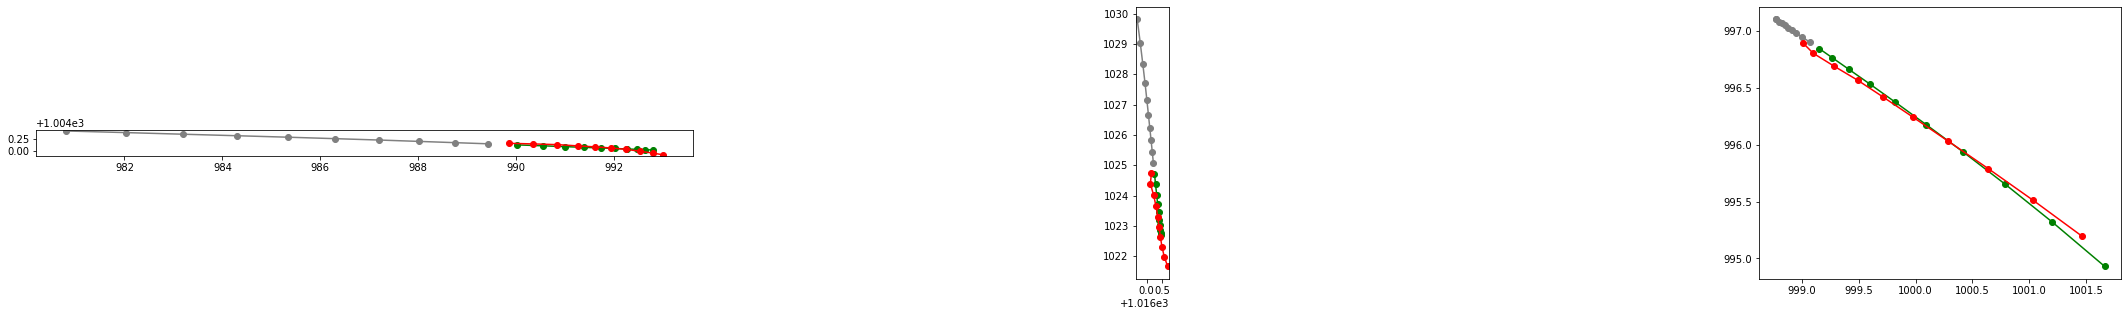

In [51]:
print_single_trajectory(scene_x_train_inv,scene_y_train_inv, results_train_inv,3,20) # n,index

In [26]:
# Write train predictions to file
def write_to_csv(scene_x_train_inv,results_train_inv,dataframe_raw,csv_out_path):
    scene_x_train_inv_xy = scene_x_train_inv[:, :, 0:2] # Take only x and y features
    # add the ground truth to predicted trajectory
    df_results = np.concatenate((scene_x_train_inv_xy, results_train_inv), axis=1)
    # convert the 3D object to a 2D object
    df_results = np.reshape(df_results,(-1,2))
    df_results = pd.DataFrame(data = df_results,columns = ['x_','y_'])
    # concatenate the predictions and ground truths with meta-data (case_id, track_id,label)
    results_merged = pd.concat([dataframe_raw, df_results], axis=1,ignore_index=False)  # merge along columns

    #write results to .csv file
    results_merged.to_csv(csv_out_path,  index = False)

    return results_merged

In [27]:
# Write to .csv file
r = write_to_csv(scene_x_train_inv, results_train_inv, dataframe_raw,csv_out_path_train)

# writed datafreme to file
r.describe()

,case_id,track_id,frame_id,timestamp_ms,x,y,vx,vy,psi_rad,length,width,label,x_,y_
count,635560.00000,635560.000000,635560.000000,635560.000000,635560.000000,635560.000000,635560.00000,635560.000000,635560.000000,635560.000000,635560.000000,635560.000000,635560.000000,635560.000000
mean,2634.16096,7.163730,20.000000,2000.000000,1018.105851,1003.645663,1.60804,-0.084499,-0.196957,4.503195,1.733667,0.493801,1018.061263,1003.656882
std,1459.69109,4.006838,11.532572,1153.257167,22.522870,9.534795,4.01982,2.041666,1.517198,0.602154,0.203770,0.646093,22.526103,9.532126
min,1.00000,1.000000,1.000000,100.000000,972.187000,964.518000,-15.58800,-14.836000,-3.142000,2.660000,1.350000,0.000000,972.187000,964.518000
25%,1356.00000,4.000000,10.500000,1050.000000,998.217000,1000.439000,-0.02200,-0.212000,-1.430000,4.230000,1.560000,0.000000,998.162231,1000.443726
50%,2728.00000,7.000000,20.000000,2000.000000,1016.885000,1003.893000,0.21000,-0.017000,-0.033000,4.450000,1.650000,0.000000,1016.854248,1003.909851
75%,4006.00000,10.000000,29.500000,2950.000000,1031.413000,1007.871000,2.85800,0.094000,0.098000,4.690000,1.910000,1.000000,1031.408000,1007.886230
max,5163.00000,24.000000,39.000000,3900.000000,1088.321000,1034.248000,17.87600,13.540000,3.142000,12.200000,2.600000,5.000000,1089.264160,1034.305176


**TEST EVALUATION**

In [28]:
# EVALUATE ON TEST SET

# Load clustered dataset
dataframe = pd.read_csv(test_dataset_path, sep=',')
# This is the test dataframe without normalization, it will be needed after to write the results to disk .csv
dataframe_raw = dataframe   

# Scale all test dataset
dataframe = scale_full_dataframe(dataframe, scaler_reload_path = scaler_reload_path)  # send a pre-calculated scaler because this is test set

# Separate clusters (flat)
scene_x_test,scene_y_test = split_groups(dataframe)

# Convert clusters to single agent arrays
scene_x_test,scene_y_test =  to_single_agent_predictor(scene_x_test,scene_y_test)

(8450, 10, 5)
(8450, 10, 2)


In [29]:
results_test = model.predict(scene_x_test)
# Uncomment if you are interested on calculate ADE over normalized trajectories
#calculate_error_batch(results,scene_y_test)

265/265 [==============================] - 1s 3ms/step


In [30]:
scene_x_test_inv,scene_y_test_inv,results_test_inv = denormalize_x_y_r(scene_x_test,scene_y_test,results_test,scaler_reload_path)

In [31]:
print("Test error ADE(m): ", calculate_error_batch(results_test_inv,scene_y_test_inv)) # Error in meters (De-normalized)

Test error ADE(m):  1.2932745547210205


ADE error:  0.0027902985272901908
ADE error:  0.002770217800828349
ADE error:  0.0030757028659722145


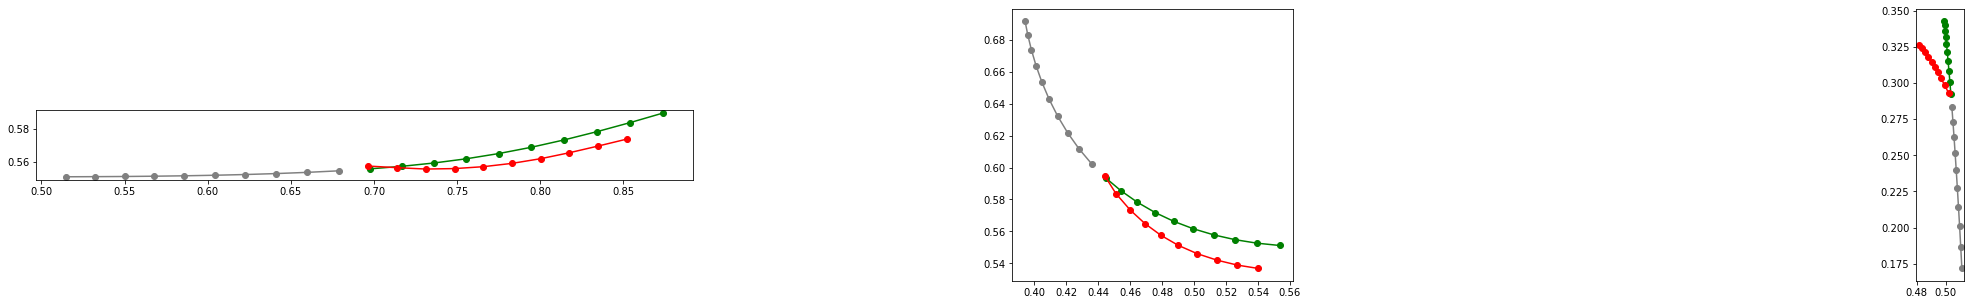

In [52]:
print_single_trajectory(scene_x_test,scene_y_test, results_test,3,100)

ADE error:  0.2806957146464784
ADE error:  0.2684220778492179
ADE error:  0.30715777240735626


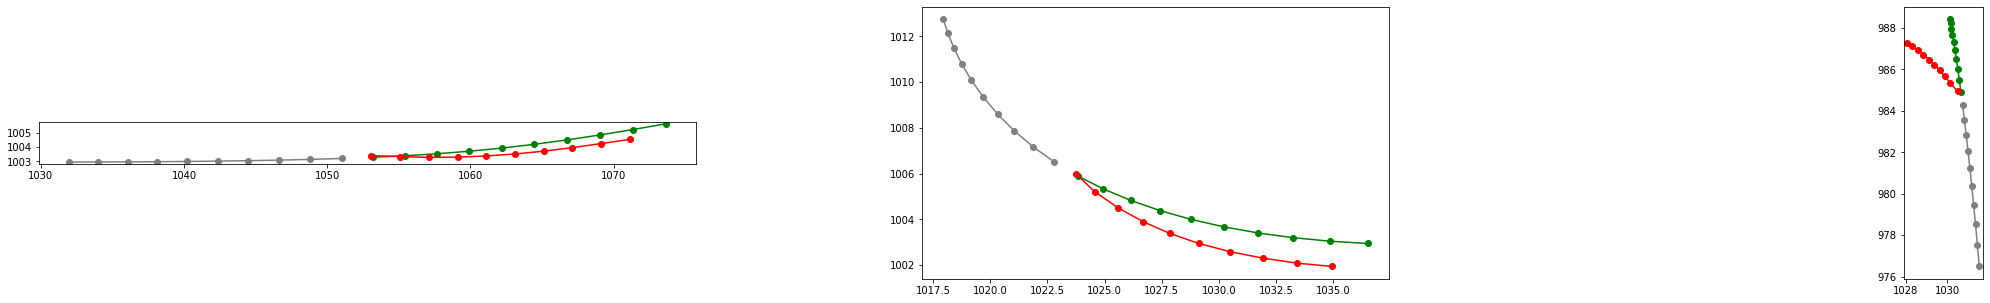

In [54]:
print_single_trajectory(scene_x_test_inv,scene_y_test_inv, results_test_inv,3,100,debug=False)

In [34]:
# Write test predictions to .csv file
r = write_to_csv(scene_x_test_inv, results_test_inv, dataframe_raw,csv_out_path_test)

# writed datafreme to file
r.describe()

,case_id,track_id,frame_id,timestamp_ms,x,y,vx,vy,psi_rad,length,width,label,x_,y_
count,169000.000000,169000.000000,169000.000000,169000.000000,169000.000000,169000.000000,169000.000000,169000.000000,169000.000000,169000.000000,169000.000000,169000.000000,169000.000000,169000.000000
mean,2555.860237,7.116095,20.000000,2000.000000,1018.053928,1003.596227,1.592749,-0.055653,-0.191354,4.517295,1.741914,0.498343,1017.400874,1002.900843
std,1473.198442,3.886890,11.532597,1153.259671,22.667016,9.499189,4.024034,2.069373,1.520074,0.593123,0.205847,0.649670,22.785160,9.545769
min,2.000000,1.000000,1.000000,100.000000,972.599000,965.004000,-14.315000,-13.491000,-3.142000,2.660000,1.350000,0.000000,972.187000,964.518000
25%,1227.000000,4.000000,10.500000,1050.000000,998.129750,1000.464000,-0.032000,-0.208000,-1.427000,4.240000,1.570000,0.000000,997.424863,999.792811
50%,2729.000000,7.000000,20.000000,2000.000000,1016.904000,1003.890000,0.219000,-0.018000,-0.032000,4.460000,1.660000,0.000000,1016.202667,1003.143341
75%,3839.000000,10.000000,29.500000,2950.000000,1031.604250,1007.837000,2.813250,0.108250,0.103000,4.700000,1.910000,1.000000,1031.298325,1007.286777
max,5156.000000,23.000000,39.000000,3900.000000,1087.974000,1034.511000,18.688000,14.200000,3.142000,12.200000,2.600000,4.000000,1088.266645,1034.248000
